# Prepare final California wildfire dataset
Main dataset is GeoMAC dataset available from NIFC.  
Accessed on 10/9/20 from https://data-nifc.opendata.arcgis.com/datasets/historic-geomac-perimeters-combined-2000-2018
All of the fires from CalFire are missing the starting date of the fire, so join with data accessed on 1/18/21 from https://frap.fire.ca.gov/mapping/gis-data/. Used years 1980-2018.

### Attach packages

In [2]:
# data wrangling
library(dplyr)
library(tidyr)
# for plotting
library(ggplot2)
library(viridis)
library(ggpubr)
# spatial packages
library(sf)
library(lwgeom)
# some source functions
work_dir <- '/Users/rebeccawillison/Documents/research/wildfire/wildfires'
source(paste(work_dir, 'src/lonlat_to_state.R', sep = '/'))
fig <- function(width, heigth){
 options(repr.plot.width = width, repr.plot.height = heigth)
 }

### Prepare CalFire dataset
Load this one first to get projection info

In [3]:
calfire_gdb <- 'data/fire19_1.gdb'
calfire <- st_read(dsn = paste(work_dir, calfire_gdb, sep = '/'), layer = 'firep19_1') %>%
  dplyr::filter(as.numeric(YEAR_) >= 1980,
                as.numeric(YEAR_) <= 2020,
                GIS_ACRES >= 10, 
                STATE == 'CA') %>%
  st_cast(., 'MULTIPOLYGON') # to fix Unknown WKB type 12 error
calfire_proj <- st_crs(calfire)
#calfire_wgs <- st_transform(calfire, 4326)
#calfire <- st_cast(calfire, 'MULTIPOLYGON') # to fix Unknown WKB type 12 error
#calfire_sp <- as_Spatial(calfire_cast) # convert to sp object 

Reading layer `firep19_1' from data source `/Users/rebeccawillison/Documents/research/wildfire/wildfires/data/fire19_1.gdb' using driver `OpenFileGDB'
Simple feature collection with 20820 features and 17 fields
geometry type:  GEOMETRY
dimension:      XY
bbox:           xmin: -373237.5 ymin: -604727.6 xmax: 519987.8 ymax: 518283.7
projected CRS:  NAD83 / California Albers


### Prepare GeoMAC dataset

In [4]:
#0. load from shapefile
geomac_path <- 'data/Interagency_Fire_Perimeter_History_All_Years_Read_Only-shp/InteragencyFirePerimeterHistory.shp'
geomacs <- st_read(paste(work_dir, geomac_path, sep = '/'))
# transform to projected CRS for calculations
geomacs <- st_transform(geomacs, calfire_proj)

Reading layer `InteragencyFirePerimeterHistory' from data source `/Users/rebeccawillison/Documents/research/wildfire/wildfires/data/Interagency_Fire_Perimeter_History_All_Years_Read_Only-shp/InteragencyFirePerimeterHistory.shp' using driver `ESRI Shapefile'
Simple feature collection with 94059 features and 20 fields (with 1 geometry empty)
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -178.8415 ymin: 3.386425 xmax: -65.33316 ymax: 70.15916
geographic CRS: WGS 84


In [5]:
#1. determine centroids of fires
centroids <- geomacs %>% 
  st_centroid() %>% 
  st_transform(., 4326) %>%
  st_coordinates() %>%
  data.frame %>%
  dplyr::rename(LONGITUDE = X,
                LATITUDE = Y)
geomacs <- cbind(geomacs, centroids) %>% dplyr::filter(!is.na(LONGITUDE))

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”


In [6]:
#2. determine state from centroids (use high resolution state boundaries)
USA_gadm <- st_read(dsn = paste(work_dir, 'data/gadm36_USA.gpkg', sep = '/'), layer = 'gadm36_USA_1')
states <- lonlat_to_state(centroids %>% drop_na, states = USA_gadm, name_col = 'NAME_1')
geomacs$STATE <- states

Reading layer `gadm36_USA_1' from data source `/Users/rebeccawillison/Documents/research/wildfire/wildfires/data/gadm36_USA.gpkg' using driver `GPKG'
Simple feature collection with 51 features and 10 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -179.1506 ymin: 18.90986 xmax: 179.7734 ymax: 72.6875
geographic CRS: WGS 84


Many points still fall outside California perimeter (zoomed in to California region):

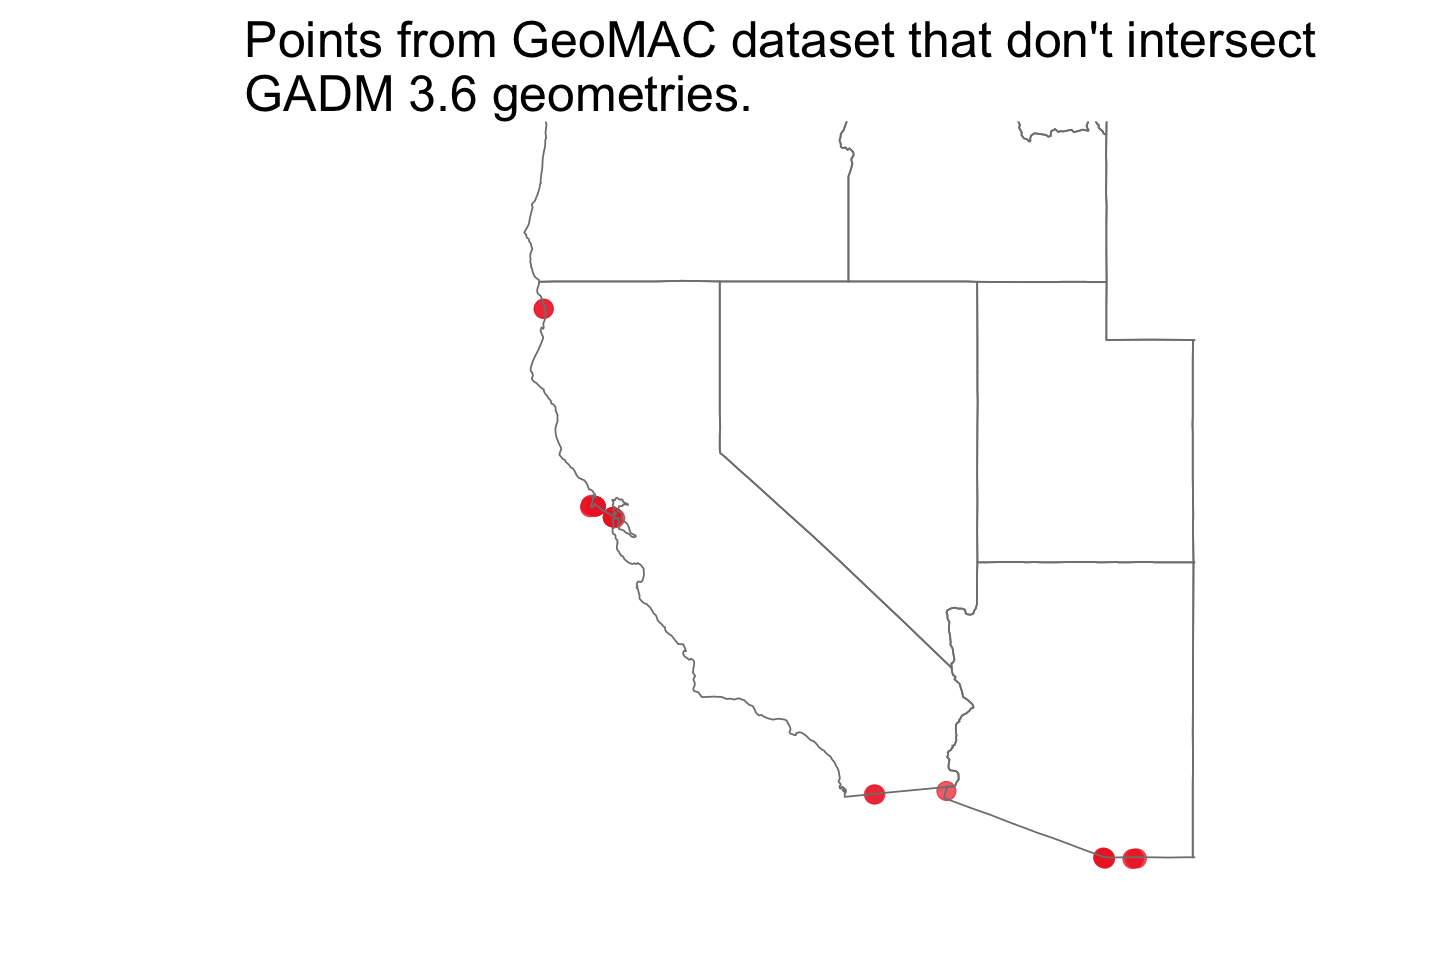

In [7]:
fig(12,8)
ggplot(geomacs %>% dplyr::filter(is.na(STATE)), aes(LONGITUDE, LATITUDE)) +
  geom_point(size = 5, alpha = .7, color = 'firebrick2') +
  borders("state") +
  theme_void(base_size = 25) +
  coord_map(xlim = c(-130, -110), ylim = c(30, 44)) +
  ggtitle("Points from GeoMAC dataset that don't intersect\nGADM 3.6 geometries.") 

In [8]:
#3. for fires with undetermined state from previous state, capture a few more
#   with loosely defined rules
geomacs[which(is.na(geomacs$STATE) & 
                    geomacs$LATITUDE < 42 &
                    geomacs$LATITUDE > 32.5 &
                    geomacs$LONGITUDE > -124.4 &
                    geomacs$LONGITUDE < -114.1), 'STATE'] <- 'California'
#4. filter for fires in California during time period of interest
geomac_ca <- geomacs %>%
  dplyr::filter(STATE == 'California',
                FIRE_YEAR >= '1980',
                FIRE_YEAR <= '2018',
                GIS_ACRES >= 10)
#5. get dataframe only
geomac_ca_df <- st_drop_geometry(geomac_ca)

A high number of remaining fires are missing ignition date, with the majority coming from CalFire.

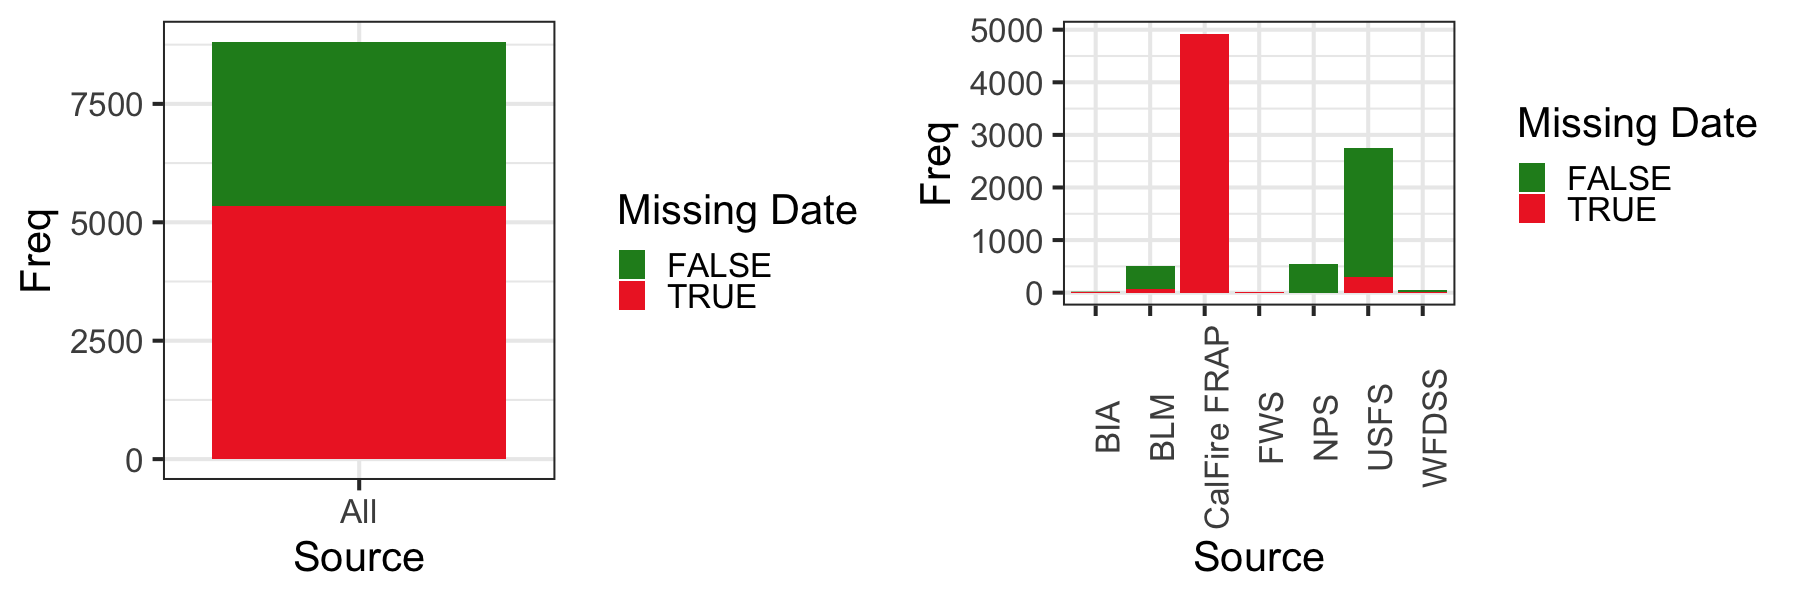

In [9]:
fig(15,5)
# check how many are missing ignition date
missing_dates <- data.frame(table(is.na(geomac_ca_df$DATE_CUR)))
a <- ggplot(missing_dates, aes('All', Freq, fill = Var1)) +
  geom_bar(stat = 'identity') +
  theme_bw(base_size = 25) +
  labs(fill = 'Missing Date', x = 'Source') +
  scale_fill_manual(values = c('forestgreen', 'firebrick2')) 

# plot missing date by source
missing_dates_by_source <- data.frame(table(geomac_ca_df$SOURCE, is.na(geomac_ca_df$DATE_CUR)))
b <- ggplot(missing_dates_by_source, aes(Var1, Freq, fill = Var2)) +
  geom_bar(stat = 'identity') +
  theme_bw(base_size = 25) +
  labs(fill = 'Missing Date', x = 'Source') +
  scale_fill_manual(values = c('forestgreen', 'firebrick2')) +
  theme(axis.text.x = element_text(angle = 90))
ggarrange(a, b)

Compare number of fires in CalFire dataset to number of fires in GeoMAC dataset that come from CalFire:

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



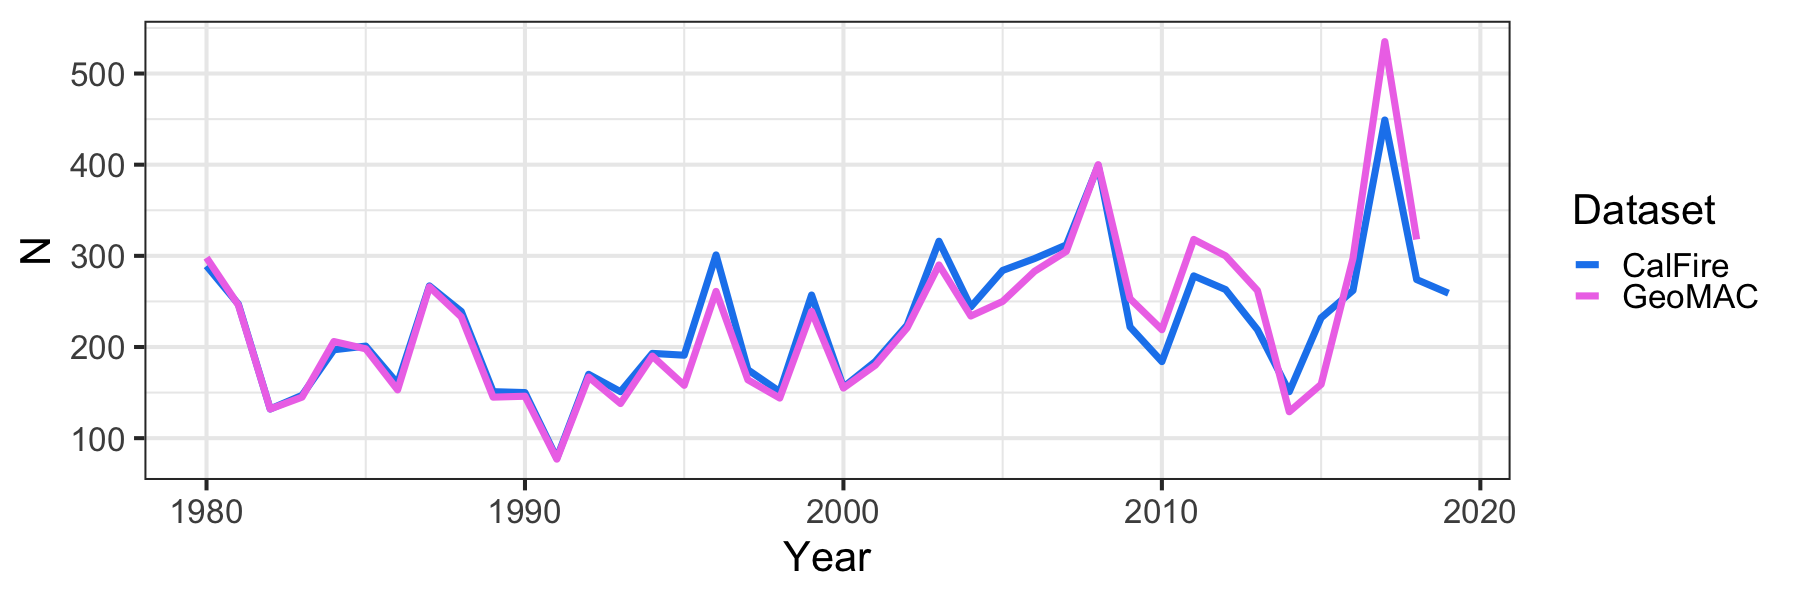

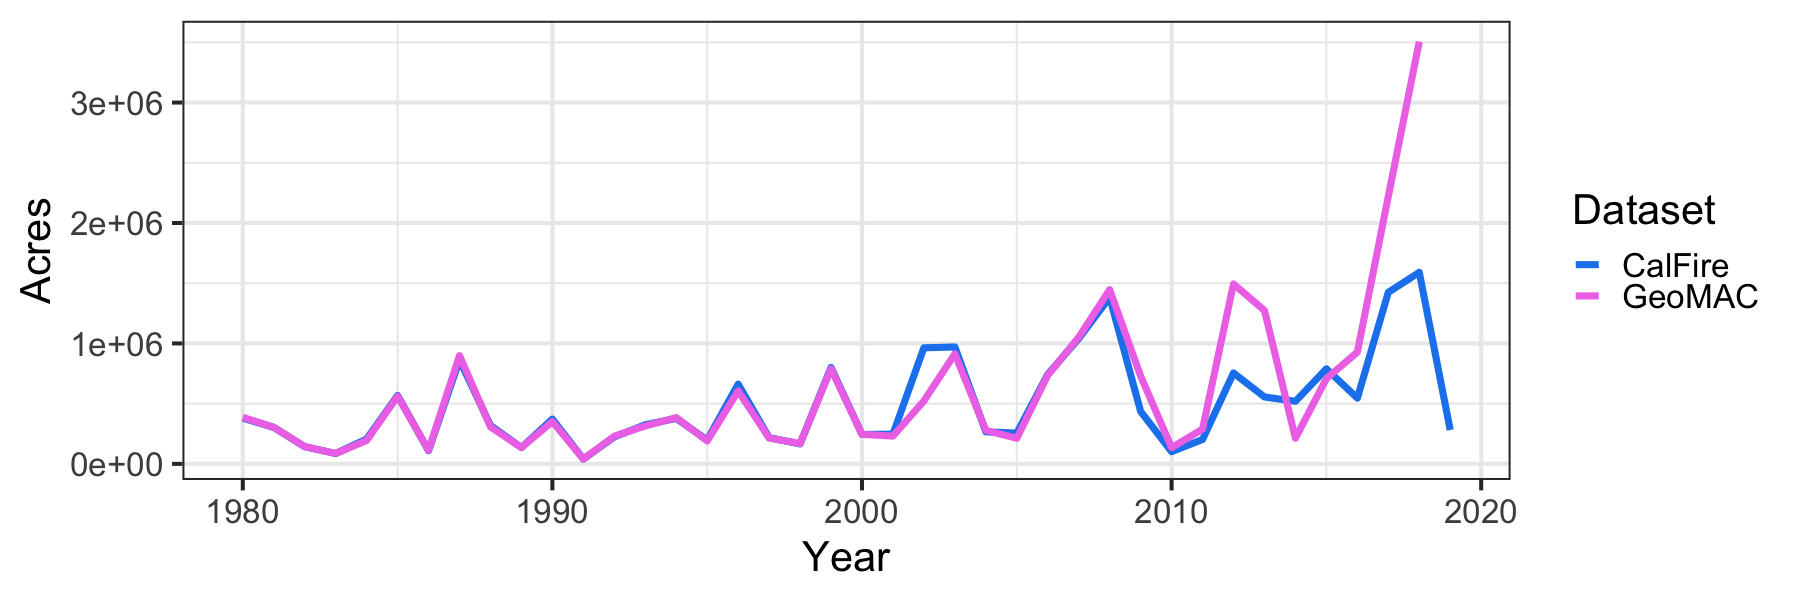

In [10]:
## summarize CalFire
calfire_nfires <- st_drop_geometry(calfire) %>%
  dplyr::group_by(YEAR_) %>%
  dplyr::summarize(N = n(),
                   Acres = sum(GIS_ACRES)) %>%
  dplyr::rename(Year = YEAR_) %>%
  dplyr::mutate(Dataset = 'CalFire')

## summarize GeoMAC
geomac_nfires <- geomac_ca_df %>%
  #dplyr::filter(!(FID %in% c(43622, 81013, 43126))) %>%
  dplyr::group_by(FIRE_YEAR) %>%
  dplyr::summarise(N = n(),
                  Acres = sum(GIS_ACRES)) %>%
  dplyr::rename(Year = FIRE_YEAR) %>%
  dplyr::mutate(Dataset = 'GeoMAC')

## join together
nfires <- calfire_nfires %>%
  dplyr::bind_rows(geomac_nfires)

## plot total number of fires
ggplot(nfires, aes(as.numeric(as.character(Year)), N, group = Dataset, color = Dataset)) +
  geom_line(size = 2) +
  theme_bw(base_size = 25) +
  scale_color_manual(values = c('dodgerblue2', 'orchid2', 'orange')) +
  labs(x = 'Year')

## plot total acres burned
ggplot(nfires, aes(as.numeric(as.character(Year)), Acres, group = Dataset, color = Dataset)) +
  geom_line(size = 2) +
  theme_bw(base_size = 25) +
  scale_color_manual(values = c('dodgerblue2', 'orchid2', 'orange')) +
  labs(x = 'Year')

GeoMAC (all sources) and CalFire are very similar in total numbers, although later years start to show more deviations. Fires can be cross-referenced using LOCAL_NUM in GeoMAC and INC_NUM in CalFire. 

In [11]:
geomac_local_nums <- unique(geomac_ca_df$LOCAL_NUM)
calfire_inc_nums <- unique(calfire$INC_NUM)
geomac_in_calfire <- geomac_local_nums[geomac_local_nums %in% calfire_inc_nums]
calfire_in_geomac <- calfire_inc_nums[calfire_inc_nums %in% geomac_local_nums]

message(paste('Unique GeoMAC LOCAL_NUM:', length(geomac_local_nums)))
message(paste('Unique CalFire INC_NUM:', length(calfire_inc_nums)))
message(paste0('Fires in common: ', 
               length(geomac_in_calfire), " (",  
               round(length(geomac_in_calfire)/length(geomac_local_nums)*100),
               "% of GeoMAC)"))

geomac_not_in_calfire <- geomac_ca_df %>% 
  dplyr::filter(!(LOCAL_NUM %in% unique(calfire$INC_NUM)),
                !is.na(DATE_CUR))
message(paste('Number of GeoMAC records not in CalFire (that have dates):', nrow(geomac_not_in_calfire)))
table(geomac_not_in_calfire$SOURCE)

calfire_not_in_geomac <- calfire %>% 
  dplyr::filter(!(INC_NUM %in% unique(geomac_ca_df$LOCAL_NUM)),
                !is.na(ALARM_DATE))
message(paste('Number of CalFire records not in GeoMAC (that have dates, but dates may not be sensible):', nrow(calfire_not_in_geomac)))
table(calfire_not_in_geomac$AGENCY)

Unique GeoMAC LOCAL_NUM: 5140

Unique CalFire INC_NUM: 4992

Fires in common: 4038 (79% of GeoMAC)

Number of GeoMAC records not in CalFire (that have dates): 1447




  BIA   BLM   NPS  USFS WFDSS 
    7   448   449   517    26 

Number of CalFire records not in GeoMAC (that have dates, but dates may not be sensible): 1244




BIA BLM CCO CDF DOD FWS LRA NPS USF 
  5 227  61 152   1  18   6  96 678 

Randomly checking matching sources and years from both datasets I did not notice any fires that appear to be non-matching duplicates. Conclusion: it is reasonable to combine both datasets and gain additional fires.

### Join GeoMAC and CalFire to make one dataset to rule them all

#### 1. All of Calfire
Start with CalFire because more complete attributes

In [12]:
# get centroids from calfire dataset
centroids <- calfire %>% 
  st_centroid() %>% 
  st_transform(., 4326) %>%
  st_coordinates() %>%
  data.frame %>%
  dplyr::rename(LONGITUDE = X,
                LATITUDE = Y)
calfire <- cbind(calfire, centroids)

data1 <- st_drop_geometry(calfire) %>% 
  dplyr::select(YEAR_, AGENCY, INC_NUM, ALARM_DATE, GIS_ACRES, LONGITUDE, LATITUDE) %>%
  dplyr::rename(FIRE_YEAR = YEAR_,
                SOURCE = AGENCY,
                LOCAL_NUM = INC_NUM,
                DATE_CUR = ALARM_DATE) %>%
  dplyr::mutate(DATE_CUR = as.Date(DATE_CUR)) %>%
  dplyr::filter(!is.na(DATE_CUR))

Warning message in st_centroid.sf(.):
“st_centroid assumes attributes are constant over geometries of x”


#### 2. Add fires in GeoMAC not in CalFire

In [13]:
data2 <- geomac_ca_df %>%
  dplyr::filter(!(LOCAL_NUM %in% unique(calfire$INC_NUM))) %>%
  dplyr::select(FIRE_YEAR, SOURCE, LOCAL_NUM, DATE_CUR, GIS_ACRES, LONGITUDE, LATITUDE) %>%
  dplyr::mutate(DATE_CUR = as.Date(substr(DATE_CUR, 1, 8), '%Y%m%d'),
                testYear = format(DATE_CUR, '%Y')) %>%
  dplyr::filter(FIRE_YEAR == testYear) %>%
  dplyr::select(-testYear)

#### 3. Stick them together -- nevermind IDs are not unique :(

In [ ]:
all_fires <- rbind(data1, data2)

In [ ]:
calfire_not_in_geomac %>% dplyr::filter(AGENCY == 'BIA')
geomac_not_in_calfire %>% dplyr::filter(SOURCE == 'BIA') %>% dplyr::select(-c(STATE, MAP_METHOD, USER_NAME))

In [ ]:
geomac_notCF <- subset(geomac_ca, !(LOCAL_NUM %in% unique(calfire$INC_NUM)))
leaflet(geomac_notCF) %>%
 addProviderTiles(providers$Esri.WorldImagery) %>%
 addPolygons()

In [ ]:
ids <- data1 %>%
  dplyr::group_by(LOCAL_NUM, SOURCE) %>%
  dplyr::summarize(N = n())
table(ids$N, ids$SOURCE)
head(ids %>% dplyr::filter(N>1, !(is.na(LOCAL_NUM)), LOCAL_NUM!='', LOCAL_NUM!='00000000', SOURCE == 'CCO'))

In [ ]:
all_fires %>% dplyr::filter(LOCAL_NUM == '00831236')%>% arrange(DATE_CUR)

In [ ]:
library(leaflet)
leaflet(calfire_wgs) %>%
 addProviderTiles(providers$Esri.WorldImagery) %>%
 addPolygons()

In [ ]:
library(leaflet)

In [ ]:
8224/(8234+563)

In [ ]:
geomac_wgs <- st_transform(geomac_ca, 4326)
calfire_wgs <- st_transform(calfire, 4326)

In [ ]:
head(calfire_wgs %>% dplyr::filter(INC_NUM == '00312031')) %>% arrange(ALARM_DATE)

In [ ]:
nfires %>% dplyr::filter(Year %in% c('2015','2016','2017', '2018'))

In [ ]:
#geomac_not_in_calfire <- geomac_ca_df %>% 
#  dplyr::filter(!(LOCAL_NUM %in% unique(calfire$INC_NUM)),
#                !is.na(DATE_CUR))

## summarize CalFire
#calfire_nfires <- st_drop_geometry(calfire_not_in_geomac) %>%
#  dplyr::group_by(YEAR_) %>%
#  dplyr::summarize(N = n(),
#                   Acres = sum(GIS_ACRES)) %>%
#  dplyr::rename(Year = YEAR_) %>%
#  dplyr::mutate(Dataset = 'CalFire Excess')
calfire_nfires <- data1 %>%
  dplyr::filter(!(LOCAL_NUM %in% unique(geomac_ca_df$LOCAL_NUM))) %>%
  dplyr::group_by(FIRE_YEAR) %>%
  dplyr::summarize(N = n(),
                   Acres = sum(GIS_ACRES)) %>%
  dplyr::rename(Year = FIRE_YEAR) %>%
  dplyr::mutate(Dataset = 'CalFire')

## summarize GeoMAC
geomac_nfires <- data2 %>%
  #dplyr::filter(!(FID %in% c(43622, 81013, 43126))) %>%
  dplyr::group_by(FIRE_YEAR) %>%
  dplyr::summarise(N = n(),
                  Acres = sum(GIS_ACRES)) %>%
  dplyr::rename(Year = FIRE_YEAR) %>%
  dplyr::mutate(Dataset = 'GeoMAC')

## join together
nfires <- calfire_nfires %>%
  dplyr::bind_rows(geomac_nfires)

## plot total number of fires
ggplot(nfires, aes(as.numeric(as.character(Year)), N, group = Dataset, color = Dataset)) +
  geom_line(size = 2) +
  theme_bw(base_size = 25) +
  scale_color_manual(values = c('dodgerblue2', 'orchid2', 'orange')) +
  labs(x = 'Year', title = 'Excess fires (complete data)')

## plot total acres burned
ggplot(nfires, aes(as.numeric(as.character(Year)), Acres, group = Dataset, color = Dataset)) +
  geom_line(size = 2) +
  theme_bw(base_size = 25) +
  scale_color_manual(values = c('dodgerblue2', 'orchid2', 'orange')) +
  labs(x = 'Year')

In [ ]:
tmp <- geomac_not_in_calfire %>% dplyr::filter(FIRE_YEAR == '2018') %>% dplyr::arrange(desc(GIS_ACRES)) %>% head
tmp[1,'LATITUDE'] == tmp[2, 'LATITUDE']
tmp[1,'LONGITUDE'] == tmp[2, 'LONGITUDE']

In [ ]:
nfires